In [2]:
import numpy as np
import sys
sys.path.insert(0,'../PETITE/')
from AllProcesses import *

import os
from copy import deepcopy
import random as rnd
import itertools
from multiprocessing import Pool
import pickle
from functools import partial

# Test creating a pickle for phase space generation

In [4]:
def create_param_dict(mV, A, Z, mT):
    """
    Creates a parameter dictionary
    """
    params = {'me' : 511e-6, 'alphaEM': 1./137}
    params.update({'A': A, 'Z': Z, 'mT': mT})
    params.update({'mV':mV})
    return params


def RetSamp(params, brem_file_prefix, initial_energy_list, initial_energy_index):

    strsaveB = brem_file_prefix + str(initial_energy_index) + ".p"

    if os.path.exists(strsaveB):
        print("Already completed this point for Bremsstrahlung\n")
        tr = 5.0
    else:
        brem_params = deepcopy(params)

        Ei = initial_energy_list[initial_energy_index]
        brem_params['Ebeam'] = Ei
        s0 = DBrem_S_T(brem_params, mode="Pickle", brem_method=params['brem_mode'])
        pickle.dump(s0, open(strsaveB, "wb"))
        tr = 6.0

    return tr

def generate_vector_mass_string(mV):
    return str(int(np.floor(mV*1000.)))+"MeV"
    
def make_pickles(mV, A, Z, mT, brem_mode='exact_tree_level'):
    """
    Generate vegas integrator pickles for the following parameters:
        mV : dark vector mass in GeV
        A : target atomic mass number
        Z : target atomic number
        mT : target mass in GeV
    """
    
    vec_mass_string = generate_vector_mass_string(mV)

    initial_energy_list = [1., 15.]

    energy_index_list = range(len(initial_energy_list))

    Dir0 = os.getcwd()

    svDir = Dir0 + "/DarkBremPickes_TMP/"
    if os.path.exists(svDir) == False:
        os.system("mkdir " + svDir)
    
    brem_file_prefix = svDir + "BremPickles_" + vec_mass_string + "_"
    
    params = create_param_dict(mV, A, Z, mT)
    params['brem_mode'] = brem_mode
    
    pool = Pool()
    res = pool.map(partial(RetSamp, params, brem_file_prefix, initial_energy_list), energy_index_list)

    ts = np.array([pickle.load(open(brem_file_prefix+str(ki)+".p", "rb")) for ki in energy_index_list])
    np.save("./ElectronPositron_BremPickles_"+vec_mass_string, np.transpose([initial_energy_list, ts]))

    #Cleanup
    for ki in energy_index_list:
        os.system("rm " + brem_file_prefix + str(ki) + ".p")
        


In [20]:
0.938*27

25.325999999999997

In [20]:
#params = {'me' : 511e-6, 'alphaEM': 1./137}
#params.update({'A': 27, 'Z': 13., 'mT': 0.938*27})
#params.update({'mV':0.1, 'Ebeam': 20.})
make_pickles(0.1, 27, 13, 0.938*27, brem_mode='exact_tree_level')

Integrator set upIntegrator set up

Input parameters = Input parameters =   [1.0, 0.000511, 0.1, 13, 0.0072992700729927005][15.0, 0.000511, 0.1, 13, 0.0072992700729927005]

Burn-in complete
Burn-in complete
Fully Integrated
{'me': 0.000511, 'alphaEM': 0.0072992700729927005, 'A': 27, 'Z': 13, 'mT': 25.325999999999997, 'mV': 0.1, 'brem_mode': 'exact_tree_level', 'Ebeam': 1.0} 0.07599886335535655
Fully Integrated
{'me': 0.000511, 'alphaEM': 0.0072992700729927005, 'A': 27, 'Z': 13, 'mT': 25.325999999999997, 'mV': 0.1, 'brem_mode': 'exact_tree_level', 'Ebeam': 15.0} 0.41774997494947336


# Test making an unweighted sample

In [21]:
np.load('./ElectronPositron_BremPickles_100MeV.npy',allow_pickle=True)

array([[1.0, <vegas._vegas.Integrator object at 0x55ad1a68e980>],
       [15.0, <vegas._vegas.Integrator object at 0x55ad1a692e80>]],
      dtype=object)

In [11]:
# again, need to decide how to do unweighing here
# may be save some target and mass info in the pickle too?
# 
NPts = 30000
dvm = '100MeV'
PickDir = '.'
BremSamp0 = np.load(PickDir+"/ElectronPositron_BremPickles_"+dvm+".npy", allow_pickle=True)
UnWS_Brem, XSecBrem = [], []
for ki in range(len(BremSamp0)):
    Ee, integrand = BremSamp0[ki]
    print("Ee = ", Ee, "\t", integrand.settings())
    
    pts = []

    xs0 = 0.0
    
    params = create_param_dict(0.1, 27, 13, 0.938*27)
    params['Ebeam'] = Ee
    
    num_iter = 0 # number of vegas iterations completed to generate sample
    while len(pts) < 10.*NPts:
        for x, wgt in integrand.random():
            MM0 = wgt*dsig_etl_helper(params, x)#dSDBrem_dP_T([Ee, meT, MVT, ZT, alT], x)
            xs0 += MM0
            #pts.append(np.concatenate([x, [MM0, MM0*FF]]))
            if MM0 > 0.:
                pts.append(np.concatenate([x, [MM0]]))

        num_iter += 1
    xs0 = xs0/num_iter
    #print(Ee, len(pts), xs0)   
    UnWeightedScreening = GetPts(pts, NPts, WgtIndex=3, LenRet=3)
    UnWS_Brem.append(UnWeightedScreening)
    XSecBrem.append([Ee, xs0])
    print(Ee, len(pts), len(UnWS_Brem[ki]), xs0)

Ee =  1.0 	 Integrator Settings:
    10000 (approx) integrand evaluations in each of 10 iterations
    number of:  strata/axis = [11 11 10]
                increments/axis = [ 990  990 1000]
                h-cubes = 1210  evaluations/h-cube = 2 (min)
                h-cubes/batch = 10000  processors = 1
    minimize_mem = False
    adapt_to_errors = False
    damping parameters: alpha = 0.5  beta= 0.75
    limits: h-cubes < 1e+09  evaluations/h-cube < 1e+06
    accuracy: relative = 0  absolute accuracy = 0

    axis 0 covers (0.1, 0.999489)
    axis 1 covers (-1.0, 1.0)
    axis 2 covers (0.0, 1.9268098826906546)

1.0 306835 0.07589781448790799
1.0 306835 30000 0.07589781448790799
Ee =  15.0 	 Integrator Settings:
    10000 (approx) integrand evaluations in each of 10 iterations
    number of:  strata/axis = [11 11 10]
                increments/axis = [ 990  990 1000]
                h-cubes = 1210  evaluations/h-cube = 2 (min)
                h-cubes/batch = 10000  processors = 1
  

In [12]:
BremSamp0

array([[1.0, <vegas._vegas.Integrator object at 0x55766034df20>],
       [15.0, <vegas._vegas.Integrator object at 0x5576643f6f90>]],
      dtype=object)

In [8]:
def GetPts(Dist, npts, WgtIndex=4, LenRet=4):
    """If weights are too cumbersome, this function returns a properly-weighted sample from Dist"""
    ret = []
    tochoosefrom = [pis for pis in range(len(Dist))]
    choicesgetter = rnd.choices(tochoosefrom, np.transpose(Dist)[WgtIndex], k=npts)
    for cg in choicesgetter:
        ret.append(Dist[cg][:LenRet])

    return ret

In [7]:
pts

[array([5.06745145e-01, 9.99990490e-01, 8.34784518e-07, 3.01855210e-05]),
 array([6.01649237e-01, 9.99993171e-01, 7.29488210e-07, 4.41178923e-05]),
 array([5.65889049e-01, 9.99994361e-01, 5.86367797e-07, 2.41767047e-05]),
 array([7.27970362e-01, 9.99993416e-01, 5.44908314e-07, 3.56473107e-05]),
 array([5.90982957e-01, 9.99995026e-01, 6.86177890e-07, 3.23964196e-05]),
 array([6.43534916e-01, 9.99997680e-01, 3.70815203e-07, 8.10524716e-06]),
 array([5.13028736e-01, 9.99994890e-01, 8.38472859e-07, 2.04362510e-05]),
 array([4.60836610e-01, 9.99998075e-01, 8.43351193e-07, 5.40866078e-06]),
 array([5.49252160e-01, 9.99997826e-01, 7.28066649e-07, 1.27823574e-05]),
 array([5.57025111e-01, 9.99995303e-01, 6.90939523e-07, 2.04349159e-05]),
 array([6.41851360e-01, 9.99997911e-01, 5.68248790e-07, 2.53165552e-05]),
 array([8.03533634e-01, 9.99997063e-01, 5.01943726e-07, 3.24358985e-05]),
 array([7.95162215e-01, 9.99997358e-01, 4.19900971e-07, 2.73902599e-05]),
 array([8.08983427e-01, 9.99997920e-01

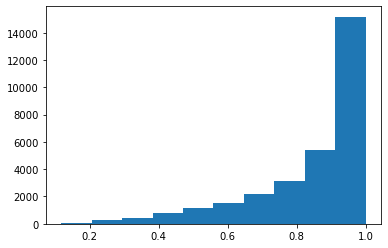

(array([1.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 5.0000e+00,
        8.0000e+00, 1.3000e+01, 3.6000e+01, 1.2700e+02, 2.9806e+04]),
 array([0.33901123, 0.4051101 , 0.47120898, 0.53730786, 0.60340673,
        0.66950561, 0.73560449, 0.80170336, 0.86780224, 0.93390112,
        0.99999999]),
 <BarContainer object of 10 artists>)

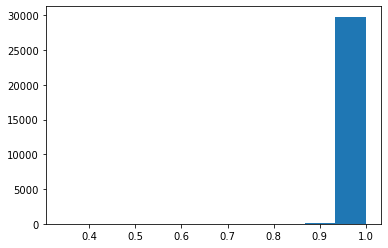

In [19]:
import matplotlib.pyplot as plt
plt.hist(np.array(UnWS_Brem[0])[:,0])
plt.show()
plt.hist(np.array(UnWS_Brem[0])[:,1])